시퀀스 데이터를 처리하는 기본적인 딥러닝 모델은 순환 신경망과 1D 컨브넷 두 가지입니다.

- 문서 분류나 시계열 분류 : 예를 들어 글의 주제나 책의 저자 식별하기
- 시계열 비교 : 예를 들어 두 문서나 두 주식 가격이 얼마나 밀접하게 관련이 있는지 추정하기
- 시퀀스-투-시퀀스 학습 : 예를 들어 영어 문장을 프랑스어로 변환하기
- 감성 분석 : 예를 들어 트윗이나 영화 리뷰가 긍정적인지 부정적인지 분류하기
- 시계열 예측 : 예를 들어 어떤 지역의 최근 날씨 데이터가 주어졌을 때 향후 날씨 예측하기

# 텍스트 데이터 다루기
텍스트는 가장 흔한 시퀀스 형태의 데이터입니다. 텍스트를 수치형 텐서로 변환하는 과정을 텍스트 벡터화라고 합니다.

- 텍스트를 단어로 나누고 각 단어를 하나의 벡터로 변환합니다.
- 텍스트를 문자로 나누고 각 문자를 하나의 벡터로 변환합니다.
- 텍스트에서 단어나 문자의 n-그램을 추출하여 각 n-그램을 하나의 벡터로 변환합니다. n-그램은 연속된 단어나 문자의 그룹으로 텍스트에서 단어나 문자를 하나씩 이동하면서 추출합니다.

텍스트를 나누는 이런 단위(단어, 문자, n-그램)를 토큰이라고 합니다. 그리고 텍스트를 토큰으로 나누는 작업을 토큰화라고 합니다.
토큰과 벡터를 연결하는 방법은 원 핫 인코딩과 토큰 임베딩이 있습니다.

## 단어와 문자의 원-핫 인코딩
원-핫 인코딩은 토큰을 벡터로 변환하는 가장 일반적이고 기본적인 방법입니다.

In [1]:
# 단어 수준의 원-핫 인코딩 하기
import numpy as np

samples = ['The cat sat on the mat.', 'The dog ate my homework.']
token_index = {}
for sample in samples:
    for word in sample.split():
        if word not in token_index:
            token_index[word] = len(token_index) + 1
            
max_length = 10

results = np.zeros(shape=(len(samples),
                         max_length,
                         max(token_index.values()) + 1))
for i, sample in enumerate(samples):
    for j, word in list(enumerate(sample.split()))[:max_length]:
        index = token_index.get(word)
        results[i, j, index] = 1.

In [2]:
# 문자 수준의 원-핫 인코딩하기
import string

samples = ['The cat sat on the mat.', 'The dog ate my homework.']
characters = string.printable
token_index = dict(zip(characters, range(1, len(characters) + 1)))

max_length = 50
results = np.zeros((len(samples), max_length, max(token_index.values()) + 1))
for i, sample in enumerate(samples):
    for j, character in enumerate(sample):
        index = token_index.get(character)
        results[i, j, index] = 1.

In [3]:
# 케라스를 사용한 원-핫 인코딩하기

from keras.preprocessing.text import Tokenizer

samples = ['The cat sat on the mat.', 'The dog ate my homework.']

tokenizer = Tokenizer(num_words=1000)
tokenizer.fit_on_texts(samples)

sequences = tokenizer.texts_to_sequences(samples)

one_hot_results = tokenizer.texts_to_matrix(samples, mode='binary')
word_index = tokenizer.word_index
print('%s개의 고유한 토큰을 찾았습니다.' % len(word_index))

9개의 고유한 토큰을 찾았습니다.


In [4]:
# 해싱 기법을 사용한 단어 수준의 원-핫 인코딩하기

samples = ['The cat sat on the mat.', 'The dog ate my homework.']

dimensionality = 1000
max_length = 10

results = np.zeros((len(samples), max_length, dimensionality))
for i, sample in enumerate(samples):
    for j, word in list(enumerate(sample.split()))[:max_length]:
        index = abs(hash(word)) % dimensionality
        results[i, j, index] = 1.

## 단어 임베딩 사용하기
보통 256차원, 512차원 또는 큰 어휘 사전을 다룰 때는 1,024차원의 단어 임베딩을 사용합니다. 2만 개의 토큰으로 이루어진 어휘 사전을 만들려면 원-핫 인코딩은 20,000차원 또는 그 이상의 벡터일 경우가 많습니다. 따라서 단어 임베딩이 더 많은 정보를 적은 차원에 저장합니다.

- (문서 분류나 감성 예측 같은) 관심 대상인 문제와 함께 단어 임베딩을 학습합니다. 이런 경우에는 랜덤한 단어 벡터로 시작해서 신경망의 가중치를 학습하는 것과 같은 방식으로 단어 벡터를 학습합니다.
- 풀려는 문제가 아니고 다른 머신 러닝 작업에서 미리 계산된 단어 임베딩을 로드합니다. 이를 사전 훈련된 단어 임베딩이라고 합니다.

## Embedding 층을 사용하여 단어 임베딩 학습하기
단어와 밀집 벡터를 연관 짓는 가장 간단한 방법은 랜덤하게 벡터를 선택하는 것입니다. 이 방식의 문제점은 임베딩 공간이 구조적이지 않다는 것입니다.
실제 단어 임베딩 공간에서 의미 있는 기하학적 변환의 일반적인 예는 '성별' 벡터와 '복수'벡터입니다. 예를 들어 'king'벡터에 'female'벡터를 더하면 'queen'벡터가 됩니다. 'plural'벡터를 더하면 'kings'가 됩니다.  
Embedding 층을 정수 인덱스를 밀집 벡터로 매핑하는 딕셔너리로 이해하는 것이 가장 좋습니다. 정수를 입력으로 받아 내부 딕셔너리에서 이 정수에 연관된 벡터를 찾아 반환합니다.  
Embedding 층은 크기가 (samples, sequence_length)인 2D 정수 벡터를 입력으로 받고, (samples, sequence_length, embedding_dimensionality)인 3D 실수형 텐서를 반환합니다.

In [5]:
from keras.layers import Embedding

embedding_layer = Embedding(1000, 64)

In [10]:
# %load np_load_allow_pickle_True.py
import numpy as np 
np_load_old = np.load
np.load = lambda *a, **k: np_load_old(*a, allow_pickle=True, **k)

# np.load 사용 후 반드시 아래 코드를 실행할 것!!!
# np.load = np_load_old

In [11]:
from keras.datasets import imdb
from keras import preprocessing

max_features = 10000
maxlen = 20

(x_train, y_train), (x_test, y_test) = imdb.load_data(num_words=max_features)

x_train = preprocessing.sequence.pad_sequences(x_train, maxlen=maxlen)
x_test = preprocessing.sequence.pad_sequences(x_test, maxlen=maxlen)

In [12]:
from keras.models import Sequential
from keras.layers import Flatten, Dense, Embedding

model = Sequential()
model.add(Embedding(10000, 8, input_length=maxlen))

model.add(Flatten())

model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])
model.summary()

history = model.fit(x_train, y_train,
                   epochs=10,
                   batch_size=32,
                   validation_split=0.2)





Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 20, 8)             80000     
_________________________________________________________________
flatten_1 (Flatten)          (None, 160)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 161       
Total params: 80,161
Trainable params: 80,161
Non-trainable params: 0
_________________________________________________________________

Train on 20000 samples, validate on 5000 samples
Epoch 1/10
20000/20000 [==============================] - 2s 108us/step - loss: 0.6759 - acc: 0.6043 - val_loss: 0.6398 - val_acc: 0.6810
Epoch 2/10
20000/20000 [==============================] - 1s 73us/step - loss: 0.5657 - acc: 0.7428 - val_loss: 0.54

## 사전 훈련된 단어 임베딩 사용하기
사전 훈련된 컨브넷을 사용하는 이유와 같다.(= 소량 데이터를 학습시키기 위함)  
가장 유명한 것은 word2vec과 GloVe이다.

## 모든 내용을 적용하기 : 원본 텍스트에서 단어 임베딩까지

In [3]:
import os

imdb_dir = './datasets/aclImdb/'
train_dir = os.path.join(imdb_dir, 'train')

labels = []
texts = []

for label_type in ['neg', 'pos']:
    dir_name = os.path.join(train_dir, label_type)
    for fname in os.listdir(dir_name):
        if fname[-4:] == '.txt':
            f = open(os.path.join(dir_name, fname), encoding='utf8')
            texts.append(f.read())
            f.close()
            if label_type == 'neg':
                labels.append(0)
            else:
                labels.append(1)

In [4]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
import numpy as np

maxlen = 100
training_samples = 200
validation_samples = 10000
max_words = 10000

tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(texts)
sequences = tokenizer.texts_to_sequences(texts)

word_index = tokenizer.word_index
print('%s개의 고유한 토큰을 찾았습니다.' % len(word_index))

data = pad_sequences(sequences, maxlen=maxlen)
labels = np.asarray(labels)
print('데이터 텐서의 크기:', data.shape)
print('레이블 텐서의 크기:', labels.shape)

indices = np.arange(data.shape[0])
np.random.shuffle(indices)
data = data[indices]
labels = labels[indices]

x_train = data[:training_samples]
y_train = labels[:training_samples]
x_val = data[training_samples: training_samples + validation_samples]
y_val = labels[training_samples: training_samples + validation_samples]

88582개의 고유한 토큰을 찾았습니다.
데이터 텐서의 크기: (25000, 100)
레이블 텐서의 크기: (25000,)


In [7]:
glove_dir = './datasets/'

embedding_index = {}
f = open(os.path.join(glove_dir, 'glove.6B.100d.txt'), encoding='utf8')
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embedding_index[word] = coefs
f.close()

print('%s개의 단어 벡터를 찾았습니다.' % len(embedding_index))

400000개의 단어 벡터를 찾았습니다.


In [6]:
embedding_dim = 100

embedding_matrix = np.zeros((max_words, embedding_dim))
for word, i in word_index.items():
    if i < max_words:
        embedding_vector = embedding_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector

NameError: name 'embedding_index' is not defined

In [21]:
from keras.models import Sequential
from keras.layers import Embedding, Flatten, Dense

model = Sequential()
model.add(Embedding(max_words, embedding_dim, input_length=maxlen))
model.add(Flatten())
model.add(Dense(32, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 100, 100)          1000000   
_________________________________________________________________
flatten_2 (Flatten)          (None, 10000)             0         
_________________________________________________________________
dense_2 (Dense)              (None, 32)                320032    
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 33        
Total params: 1,320,065
Trainable params: 1,320,065
Non-trainable params: 0
_________________________________________________________________


In [22]:
# 사전 훈련된 데이터를 
model.layers[0].set_weights([embedding_matrix])
model.layers[0].trainable = False

In [24]:
model.compile(optimizer='rmsprop',
             loss='binary_crossentropy',
             metrics=['acc'])
history = model.fit(x_train, y_train,
                   epochs=10,
                   batch_size=32,
                   validation_data=(x_val, y_val))
model.save_weights('pre_trained_glove_model.h5')

Train on 200 samples, validate on 10000 samples
Epoch 1/10
200/200 [==============================] - 1s 5ms/step - loss: 1.2018 - acc: 0.5000 - val_loss: 0.7379 - val_acc: 0.4967
Epoch 2/10
200/200 [==============================] - 0s 1ms/step - loss: 0.5220 - acc: 0.7550 - val_loss: 1.5121 - val_acc: 0.4936
Epoch 3/10
200/200 [==============================] - 0s 1ms/step - loss: 0.5323 - acc: 0.7400 - val_loss: 0.9402 - val_acc: 0.4942
Epoch 4/10
200/200 [==============================] - 0s 1ms/step - loss: 0.3645 - acc: 0.8550 - val_loss: 0.6827 - val_acc: 0.5661
Epoch 5/10
200/200 [==============================] - 0s 1ms/step - loss: 0.2080 - acc: 0.9950 - val_loss: 0.7032 - val_acc: 0.5615
Epoch 6/10
200/200 [==============================] - 0s 1ms/step - loss: 0.2648 - acc: 0.8800 - val_loss: 0.7341 - val_acc: 0.5431
Epoch 7/10
200/200 [==============================] - 0s 2ms/step - loss: 0.1375 - acc: 0.9800 - val_loss: 0.7051 - val_acc: 0.5676
Epoch 8/10
200/200 [========

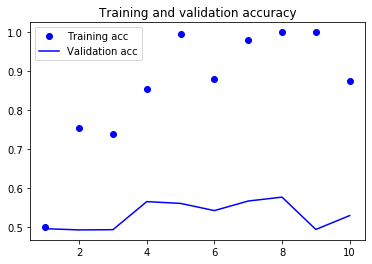

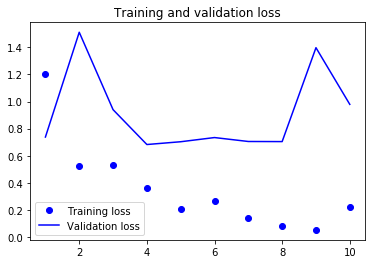

In [25]:
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [8]:
from keras.models import Sequential
from keras.layers import Embedding, Flatten, Dense

embedding_dim = 100

model = Sequential()
model.add(Embedding(max_words, embedding_dim, input_length=maxlen))
model.add(Flatten())
model.add(Dense(32, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.summary()



_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 100, 100)          1000000   
_________________________________________________________________
flatten_1 (Flatten)          (None, 10000)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 32)                320032    
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 33        
Total params: 1,320,065
Trainable params: 1,320,065
Non-trainable params: 0
_________________________________________________________________


In [9]:
model.compile(optimizer='rmsprop',
             loss='binary_crossentropy',
             metrics=['acc'])
history = model.fit(x_train, y_train,
                   epochs=10,
                   batch_size=32,
                   validation_data=(x_val, y_val))



Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where

Train on 200 samples, validate on 10000 samples
Epoch 1/10
200/200 [==============================] - 1s 4ms/step - loss: 0.6956 - acc: 0.4500 - val_loss: 0.6921 - val_acc: 0.5195
Epoch 2/10
200/200 [==============================] - 0s 2ms/step - loss: 0.5374 - acc: 0.9750 - val_loss: 0.6932 - val_acc: 0.5176
Epoch 3/10
200/200 [==============================] - 0s 2ms/step - loss: 0.3277 - acc: 0.9900 - val_loss: 0.7014 - val_acc: 0.5128
Epoch 4/10
200/200 [==============================] - 1s 3ms/step - loss: 0.1574 - acc: 1.0000 - val_loss: 0.6982 - val_acc: 0.5252
Epoch 5/10
200/200 [==============================] - 0s 2ms/step - loss: 0.0750 - acc: 1.0000 - val_loss: 0.7043 - val_acc: 0.5281
Epoch 6/10
200/200 [==============================] - 0s 2ms/step - loss: 0.0387 - acc: 1.0000 - val_loss: 0.7108 - val_acc: 0.5259
Epoch 7/10
200/200 [==============================] - 0s 2ms/st

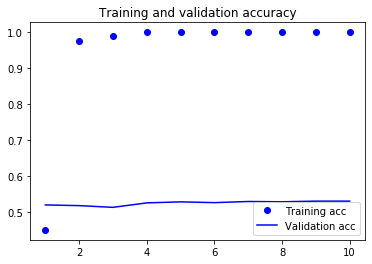

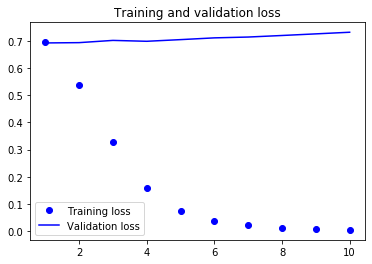

In [10]:
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [12]:
test_dir = os.path.join(imdb_dir, 'test')

labels = []
texts = []

for label_type in ['neg', 'pos']:
    dir_name = os.path.join(test_dir, label_type)
    for fname in sorted(os.listdir(dir_name)):
        if fname[-4:] == '.txt':
            f = open(os.path.join(dir_name, fname), encoding='utf8')
            texts.append(f.read())
            f.close()
            if label_type == 'neg':
                labels.append(0)
            else:
                labels.append(1)
                
sequences = tokenizer.texts_to_sequences(texts)
x_test = pad_sequences(sequences, maxlen=maxlen)
y_test = np.asarray(labels)

In [13]:
model.load_weights('pre_trained_glove_model.h5')
model.evaluate(x_test, y_test)

25000/25000 [==============================] - 1s 47us/step


[0.9933327033805848, 0.5204]

## 정리

- 원본 텍스트를 신경망이 처리할 수 있는 형태로 변환합니다.
- 케라스 모델에 Embedding 층을 추가하여 어떤 작업에 특화된 토큰 임베딩을 학습합니다.
- 데이터가 부족한 자연어 처리 문제에서 사전 훈련된 단어 임베딩을 사용하여 성능 향상을 꾀합니다.

# 순환 신경망 이해하기

완전 연결 네트워크나 컨브넷처럼 지금까지 본 모든 신경망의 특징은 메모리가 없다는 것입니다.
순환 신경망은 시퀀스의 원소를 순회하면서 지금까지 처리한 정보를 상태에 저장합니다.
요약하면 RNN은 반복할 때 이전에 계산한 정보를 재사용하는 for 루프에 지나지 않습니다.

In [ ]:
# 의사코드로 표현한 RNN

state_t = 0
for input_t in input_sequence:
    output_t = f(input_t, state_t)
    state_t = output_t

In [ ]:
# 좀 더 자세하게

state_t = 0
for input_t in input_sequence:
    output_t = activation(dot(W, input_t) + dot(U, state_t) + b)
    state_t = output_t

In [ ]:
# numpy로 구현한 간단한 RNN

import numpy as np

timesteps = 100
input_features = 32
output_features = 64

inputs = np.random.random((timesteps, input_features))

state_t = np.zeros((output_features,))

W = np.random.random((output_features, input_features))
U = np.random.random((output_features, output_features))
b = np.random.random((output_features,))

successive_outputs = []
for input_t in inputs:
    output_t = np.tanh(np.dot(W, input_t) + np.dot(U, state_t) + b)
    successive_outputs.append(output_t)
    state_t = output_t
    
final_output_sequence = np.stack(successive_outputs, axis=0)

## 케라스의 순환 층

In [2]:
from keras.models import Sequential
from keras.layers import Embedding, SimpleRNN

model = Sequential()
model.add(Embedding(10000, 32))
model.add(SimpleRNN(32))
model.summary()




_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, None, 32)          320000    
_________________________________________________________________
simple_rnn_1 (SimpleRNN)     (None, 32)                2080      
Total params: 322,080
Trainable params: 322,080
Non-trainable params: 0
_________________________________________________________________


In [3]:
model = Sequential()
model.add(Embedding(10000, 32))
model.add(SimpleRNN(32, return_sequences=True))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, None, 32)          320000    
_________________________________________________________________
simple_rnn_2 (SimpleRNN)     (None, None, 32)          2080      
Total params: 322,080
Trainable params: 322,080
Non-trainable params: 0
_________________________________________________________________


In [4]:
model = Sequential()
model.add(Embedding(10000, 32))
model.add(SimpleRNN(32, return_sequences=True))
model.add(SimpleRNN(32, return_sequences=True))
model.add(SimpleRNN(32, return_sequences=True))
model.add(SimpleRNN(32))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, None, 32)          320000    
_________________________________________________________________
simple_rnn_3 (SimpleRNN)     (None, None, 32)          2080      
_________________________________________________________________
simple_rnn_4 (SimpleRNN)     (None, None, 32)          2080      
_________________________________________________________________
simple_rnn_5 (SimpleRNN)     (None, None, 32)          2080      
_________________________________________________________________
simple_rnn_6 (SimpleRNN)     (None, 32)                2080      
Total params: 328,320
Trainable params: 328,320
Non-trainable params: 0
_________________________________________________________________


In [7]:
# %load np_load_allow_pickle_True.py
import numpy as np 
np_load_old = np.load
np.load = lambda *a, **k: np_load_old(*a, allow_pickle=True, **k)

# np.load 사용 후 반드시 아래 코드를 실행할 것!!!
# np.load = np_load_old

In [8]:
from keras.datasets import imdb
from keras.preprocessing import sequence

max_features = 10000
maxlen = 500
batch_size = 32

print('데이터 로딩...')
(input_train, y_train), (input_test, y_test) = imdb.load_data(num_words=max_features)
print(len(input_train), '훈련 시퀀스')
print(len(input_test), '테스트 시퀀스')

print('시퀀스 패딩 (samples x time)')
input_train = sequence.pad_sequences(input_train, maxlen=maxlen)
input_test = sequence.pad_sequences(input_test, maxlen=maxlen)
print('input_train 크기:', input_train.shape)
print('input_test 크기:', input_test.shape)

데이터 로딩...
25000 훈련 시퀀스
25000 테스트 시퀀스
시퀀스 패딩 (samples x time)
input_train 크기: (25000, 500)
input_test 크기: (25000, 500)


In [9]:
from keras.layers import Dense

model = Sequential()
model.add(Embedding(max_features, 32))
model.add(SimpleRNN(32))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])
history = model.fit(input_train, y_train,
                   epochs=10,
                   batch_size=128,
                   validation_split=0.2)



Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where

Train on 20000 samples, validate on 5000 samples
Epoch 1/10
20000/20000 [==============================] - 76s 4ms/step - loss: 0.6578 - acc: 0.5927 - val_loss: 0.5581 - val_acc: 0.7310
Epoch 2/10
20000/20000 [==============================] - 59s 3ms/step - loss: 0.4537 - acc: 0.8005 - val_loss: 0.4486 - val_acc: 0.7954
Epoch 3/10
20000/20000 [==============================] - 66s 3ms/step - loss: 0.3063 - acc: 0.8775 - val_loss: 0.3584 - val_acc: 0.8526
Epoch 4/10
20000/20000 [==============================] - 65s 3ms/step - loss: 0.2123 - acc: 0.9222 - val_loss: 0.4390 - val_acc: 0.8124
Epoch 5/10
20000/20000 [==============================] - 60s 3ms/step - loss: 0.1408 - acc: 0.9494 - val_loss: 0.4124 - val_acc: 0.8472
Epoch 6/10
20000/20000 [==============================] - 59s 3ms/step - loss: 0.0882 - acc: 0.9708 - val_loss: 0.4167 - val_acc: 0.8578
Epoch 7/10
20000/20000 [========

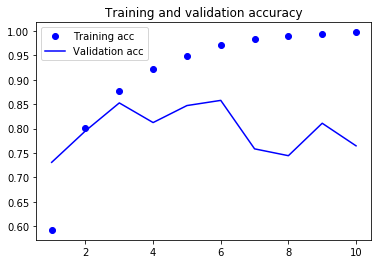

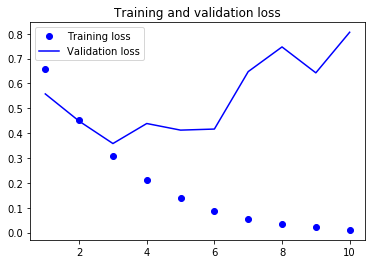

In [10]:
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

## LSTM과 GRU 층 이해하기

실전에서는 항상 이 둘 중 하나를 사용합니다. SimpleRNN은 너무 단순하기 때문입니다.

In [ ]:
# LSTM 구조의 의사코드

output_t = activation(c_t) * activation(dot(input_t, Wo) + dot(state_t, Uo) + bo)

i_t = activation(dot(state_t, Ui) + dot(input_t, Wi) + bi)
f_t = activation(dot(state_t, Uf) + dot(input_t, Wf) + bf)
k_t = activation(dot(state_t, Uk) + dot(input_t, Wk) + bk)

c_t + 1 = i_t * k_t + c_t * f_t

## 케라스를 사용한 LSTM 예제

In [11]:
from keras.layers import LSTM

model = Sequential()
model.add(Embedding(max_features, 32))
model.add(LSTM(32))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer='rmsprop',
             loss='binary_crossentropy',
             metrics=['acc'])
history = model.fit(input_train, y_train,
                   epochs=10,
                   batch_size=128,
                   validation_split=0.2)

Train on 20000 samples, validate on 5000 samples
Epoch 1/10
20000/20000 [==============================] - 110s 5ms/step - loss: 0.5012 - acc: 0.7639 - val_loss: 0.3544 - val_acc: 0.8634
Epoch 2/10
20000/20000 [==============================] - 127s 6ms/step - loss: 0.2927 - acc: 0.8846 - val_loss: 0.3257 - val_acc: 0.8602
Epoch 3/10
20000/20000 [==============================] - 126s 6ms/step - loss: 0.2313 - acc: 0.9108 - val_loss: 0.3436 - val_acc: 0.8754
Epoch 4/10
20000/20000 [==============================] - 396s 20ms/step - loss: 0.1937 - acc: 0.9274 - val_loss: 0.4573 - val_acc: 0.8712
Epoch 5/10
20000/20000 [==============================] - 292s 15ms/step - loss: 0.1726 - acc: 0.9371 - val_loss: 0.3024 - val_acc: 0.8904
Epoch 6/10
19968/20000 [============================>.] - ETA: 0s - loss: 0.1543 - acc: 0.9428

KeyboardInterrupt: 

## 정리
- RNN이 무엇이고 동작하는 방법
- LSTM이 무엇이고 긴 시퀀스에서 단순한 RNN보다 더 잘 작동하는 이유
- 케라스의 RNN 층을 사용하여 시퀀스 데이터를 처리하는 방법

# 순환 신경망의 고급 사용법

순환 신경망의 고급 사용법

- 순환 드롭아웃 : 순환 층에서 과대적합을 방지하기 위해 케라스에 내장되어 있는 드롭아웃을 사용합니다.
- 스태킹 순환 층 : 네트워크의 표현 능력을 증가시킵니다(그 대신 계산 비용이 많이 듭니다.)
- 양방향 순환 층 : 순환 네트워크에 같은 정보를 다른 방향으로 주입하여 정확도를 높이고 기억을 좀 더 오래 유지시킵니다.

## 기온 예측 문제

In [1]:
# 예나의 날씨 데이터셋 조사하기

import os

data_dir = './datasets/jena_climate'
fname = os.path.join(data_dir, 'jena_climate_2009_2016.csv')

f = open(fname)
data = f.read()
f.close()
lines = data.split('\n')
header = lines[0].split(',')
lines = lines[1:]

print(header)
print(len(lines))

['"Date Time"', '"p (mbar)"', '"T (degC)"', '"Tpot (K)"', '"Tdew (degC)"', '"rh (%)"', '"VPmax (mbar)"', '"VPact (mbar)"', '"VPdef (mbar)"', '"sh (g/kg)"', '"H2OC (mmol/mol)"', '"rho (g/m**3)"', '"wv (m/s)"', '"max. wv (m/s)"', '"wd (deg)"']
420551


In [2]:
import numpy as np

float_data = np.zeros((len(lines), len(header) - 1))
for i, line in enumerate(lines):
    values = [float(x) for x in line.split(',')[1:]]
    float_data[i, :] = values

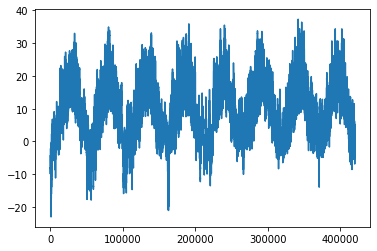

In [3]:
from matplotlib import pyplot as plt

temp = float_data[:, 1]
plt.plot(range(len(temp)), temp)

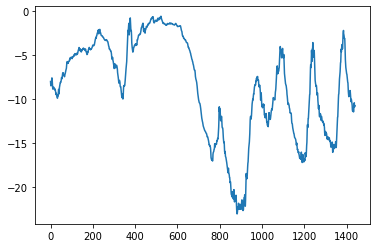

In [4]:
plt.plot(range(1440), temp[:1440])

## 데이터 준비

- lookback = 1440 : 10일 전 데이터로 돌아갑니다.
- steps = 6 : 1시간마다 데이터 포인트 하나를 샘플링합니다.
- delay = 144 : 24시간이 지난 데이터가 타깃이 됩니다.

시작하기 전에 두 가지 작업을 처리해야 합니다.

- 신경망에 주입할 수 있는 형태로 데이터를 전처리합니다. 데이터가 이미 수치형이므로 추가적인 벡터화가 필요하지 않습니다. 하지만 데이터에 있는 각 시계열 특성의 범위가 서로 다릅니다(예를 들어 온도는 일반적으로 -20도에서 +30도 사이고, 밀리바로 측정된 기압은 1,000 근처의 값입니다). 각 시계열 특성을 개별적으로 정규화하여 비슷한 범위를 가진 작은 값으로 바꾸겠습니다.
- float_data 배열을 받아 과거 데이터의 배치와 미래 타깃 온도를 추출하는 파이썬 제너레이터를 만듭니다. 이 데이터셋에 있는 샘플은 중복이 많습니다(샘플 N과 샘플 N + 1은 대부분 타임스텝이 비슷합니다). 모든 샘플을 각기 메모리에 적재하는 것은 낭비가 심하므로 대신에 원본 데이터를 사용하여 그때그때 배치를 만들겠습니다.

In [5]:
mean = float_data[:200000].mean(axis=0)
float_data -= mean
std = float_data[:200000].std(axis=0)
float_data /= std

- data : 위 코드에서 정규화한 부동 소수 데이터로 이루어진 원본 배열
- lookback : 입력으로 사용하기 위해 거슬러 올라갈 타임스텝
- delay : 타깃으로 사용할 미래의 타임스텝
- min_index와 max_index : 추출할 타임스텝의 범위를 지정하기 위한 data 배열의 인덱스, 검증 데이터와 테스트 데이터를 분리하는 데 사용합니다.
- shuffle : 샘플을 섞을지, 시간 순서대로 추출할지를 결정합니다.
- batch_size : 배치의 샘플 수
- step : 데이터를 샘플링할 타임스텝 간격. 1시간에 하나의 데이터 포인트를 추출하기 위해 6으로 지정하겠습니다.

In [7]:
def generator(data, lookback, delay, min_index, max_index, shuffle=False, batch_size=128, step=6):
    if max_index is None:
        max_index = len(data) - delay - 1
    i = min_index + lookback
    while 1:
        if shuffle:
            rows = np.random.randint(
            min_index + lookback, max_index, size=batch_size)
        else:
            if i + batch_size >= max_index:
                i = min_index + lookback
            rows = np.arange(i, min(i + batch_size, max_index))
            i += len(rows)
            
        samples = np.zeros((len(rows),
                           lookback // step,
                           data.shape[-1]))
        targets = np.zeros((len(rows),))
        for j, row in enumerate(rows):
            indices = range(rows[j] - lookback, rows[j], step)
            samples[j] = data[indices]
            targets[j] = data[rows[j] + delay][1]
        yield samples, targets

In [9]:
lookback = 1440
step = 6
delay = 144
batch_size = 128

train_gen = generator(float_data,
                     lookback=lookback,
                     delay=delay,
                     min_index=0,
                     max_index=200000,
                     shuffle=True,
                     step=step,
                     batch_size=batch_size)
val_gen = generator(float_data,
                   lookback=lookback,
                   delay=delay,
                   min_index=200001,
                   max_index=300000,
                   step=step,
                   batch_size=batch_size)
test_gen = generator(float_data,
                    lookback=lookback,
                    delay=delay,
                    min_index=300001,
                    max_index=None,
                    step=step,
                    batch_size=batch_size)

val_steps = (300000 - 200001 - lookback) // batch_size

test_steps = (len(float_data) - 300001 - lookback) // batch_size

## 상식 수준의 기준점

In [12]:
def evaluate_naive_method():
    batch_maes = []
    for step in range(val_steps):
        samples, targets = next(val_gen)
        preds = samples[:, -1, 1]
        mae = np.mean(np.abs(preds - targets))
        batch_maes.append(mae)
    print(np.mean(batch_maes))
    
evaluate_naive_method()

0.2897359729905486


In [14]:
celsius_mae = 0.29 * std[1]
celsius_mae

2.5672247338393395

## 기본적인 머신 러닝 방법

In [ ]:
from keras.models import Sequential
from keras import layers
from keras.optimizers import RMSprop

model = Sequential()
model.add(layers.Flatten(input_shape=(lookback // step, float_data.shape[-1])))
model.add(layers.Dense(32, activation='relu'))
model.add(layers.Dense(1))
model.compile(optimizer=RMSprop(), loss='mae')
history = model.fit_generator(train_gen,
                             steps_per_epoch=500,
                             epochs=20,
                             validation_data=val_gen,
                             validation_steps=val_steps)

In [ ]:
import matplotlib.pyplot as plt

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(loss) + 1)

plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

## 첫 번째 순환 신경망

In [ ]:
# GRU를 사용한 모델을 훈련

from keras.models import Sequential
from keras import layers
from keras.optimizers import RMSprop

model = Sequential()
model.add(layers.GRU(32, input_shape=(None, float_data.shape[-1])))
model.add(layers.Dense(1))

model.compile(optimizer=RMSprop(), loss='mae')
history = model.fit_generator(train_gen,
                             steps_per_epochs=500,
                             epochs=20,
                             validation_data=val_gen,
                             validation_steps=val_steps)

## 과대적합을 감소하기 위해 순환 드롭아웃 사용하기

In [ ]:
from keras.models import Sequential
from keras import layers
from keras.optimizers import RMSprop

model = Sequential()
model.add(layers.GRU(32,
                     dropout=0.2,
                     recurrent_dropout=0.2,
                     input_shape=(None, float_data.shape[-1])))
model.add(layers.Dense(1))

model.compile(optimizer=RMSprop(), loss='mae')
history = model.fit_generator(train_gen,
                             steps_per_epochs=500,
                             epochs=20,
                             validation_data=val_gen,
                             validation_steps=val_steps)

## 스태킹 순환 층

In [ ]:
from keras.models import Sequential
from keras import layers
from keras.optimizers import RMSprop

model = Sequential()
model.add(layers.GRU(32,
                     dropout=0.1,
                     recurrent_dropout=0.5,
                     return_sequences=True,
                     input_shape=(None, float_data.shape[-1])))
model.add(layers.GRU(64, activation='relu',
                    dropout=0.1,
                    recurrent_dropout=0.5))
model.add(layers.Dense(1))

model.compile(optimizer=RMSprop(), loss='mae')
history = model.fit_generator(train_gen,
                             steps_per_epochs=500,
                             epochs=20,
                             validation_data=val_gen,
                             validation_steps=val_steps)

여기서 두 가지 결론을 얻을 수 있습니다.

- 아직 충분히 과대적합을 만들지 못했기 때문에 검증 손실을 향상하기 위해서 층의 크기를 늘릴 수 있습니다. 하지만 적지 않은 계산 비용이 추가됩니다.
- 층을 추가한 만큼 도움이 되지 않았으므로, 여기서는 네트워크의 용량을 늘리는 것이 도움이 되지 않는다고 볼 수 있습니다.

## 양방향 RNN 사용하기
자연어 처리에서 자주 사용합니다. GRU나 LSTM 같은 RNN 2개를 사용합니다.

In [ ]:
from keras.datasets import imdb
from keras.preprocessing import sequence
from keras import layers
from keras.models import Sequential

max_features = 10000
maxlen = 500

(x_train, y_train), (x_test, y_test) = imdb.load_data(num_words=max_features)

x_train = [x[::-1] for x in x_train]
x_test = [x[::-1] for x in x_test]

x_train = sequence.pad_sequences(x_train, maxlen=maxlen)
x_test = sequence.pad_sequences(x_test, maxlen=maxlen)

model = Sequential()
model.add(layers.Embedding(max_features, 128))
model.add(layers.LSTM(32))
model.add(layers.Dense(1, activation='sigmoid'))

model.compile(optimizer='rmsprop',
             loss = 'binary_crossentropy',
             metrics=['acc'])
history = model.fit(x_train, y_train,
                   epochs=10,
                   batch_size=128,
                   validation_split=0.2)

In [ ]:
model = Sequential()
model.add(layers.Embedding(max_features, 32))
model.add(layers.Bidirectional(layers.LSTM(32)))
model.add(layers.Dense(1, activation='sigmoid'))

model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])
history = model.fit(x_train, y_train,
                   epochs=10,
                   batch_size=128,
                   validation_split=0.2)

In [ ]:
model = Sequential()
model.add(layers.Bidirectional(
layers.GRU(32), input_shape=(None, float_data.shape[-1])))
model.add(layers.Dense(1))

model.compile(optimizer=RMSprop(), loss='mae')
history = model.fit_generator(train_gen,
                             steps_per_epoch=500,
                             epochs=40,
                             validation_data=val_gen,
                             validation_steps=val_steps)

## 더 나아가서

- 스태킹한 각 순환 층의 유닛 수를 조정합니다. 지금 설정은 대부분 임의로 한 것이라 최적화가 덜 되었을 것입니다.
- RMSprop 옵티마이저가 사용한 학습률을 조정합니다.
- GRU 대신 LSTM 층을 사용합니다.
- 순환 층 위에 용량이 큰 완전 회귀 층을 사용합니다. 즉 유닛 수가 많은 Dense 층이나 Dense 층을 스태킹합니다.
- 최종적으로 (검증 MAE 기준으로 보았을 때) 최선의 모델을 테스트 세트에서 확인해야 합니다. 이를 잊으면 검증 세트에 과대적합된 네트워크 구조를 만들게 될 것입니다.

## 정리

- 4장에서 처음 배웠던 것처럼 새로운 문제를 해결할 때는 선택한 지표에서 상식 수준의 기준점을 설정하는 것이 좋습니다. 기준점을 가지고 있지 않으면 실제로 향상되었는지 알 수 없습니다.
- 계산 비용을 추가할지 판단하기 위해서 비용이 비싼 모델 전에 간단한 모델을 시도합니다.
- 시간 순서가 중요한 데이터가 있다면 순환 층이 적합합니다. 시계열 데이터를 펼쳐서 처리하는 모델의 성능을 쉽게 앞지를 것입니다.
- 순환 네트워크에 드롭아웃을 사용하려면 타임스텝 동안 일정한 드롭아웃 마스크와 순환 드롭아웃 마스크를 사용해야 합니다. 둘 다 케라스 순환 층에 포함되어 있습니다. 순환 층에 있는 dropout과 recurrent_dropout 매개변수를 사용하면 됩니다.
- 스태킹 RNN은 단일 RNN층보다 더 강력한 표현 능력을 제공합니다. 하지만 계산 비용이 많이 들기 때문에 항상 시도할 가치가 있지는 않습니다. (기계 번역 같은) 복잡한 문제에서 확실히 도움이 되지만 작고 간단한 문제에서는 항상 그렇지 않습니다.
- 양쪽 방향으로 시퀀스를 바라보는 양방향 RNN은 자연어 처리 문제에 유용합니다. 하지만 최근 정보가 오래된 것보다 훨씬 의미 있는 시퀀스 데이터에는 잘 동작하지 않습니다.